# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("local[*]")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-01-26 10:40 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-01-26 10:40 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-01-26 10:40 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-01-26 10:40 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-01-26 10:40 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-01-26 10:40 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-01-26 10:41 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-01-26 10:41 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-01-26 10:41 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [4]:
DATA_PATH = 'data/ml-25m'
READ_DATA_PATH = os.path.join('file:///', os.getcwd()[1:], 'data/ml-25m')

RATINGS_PATH = os.path.join(READ_DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(READ_DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(READ_DATA_PATH, 'tags.csv')

In [5]:
ratings = sc.textFile(RATINGS_PATH)

In [6]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [7]:
ratings.getNumPartitions()

21

In [8]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [9]:
ratings.count()

25000095

Количество пользователей

In [10]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 50.5 ms, sys: 1.66 ms, total: 52.2 ms
Wall time: 2min 30s


162541

Сохраним датасет в память

In [11]:
ratings = ratings.persist()

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 40.2 ms, sys: 16.9 ms, total: 57.1 ms
Wall time: 3min 38s


162541

Количество фильмов

In [13]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [14]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [15]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(118818, (5.0, ['118818', 'Frozen (2010)'])),
 (200744,
  (5.0, ['200744', 'Beyond Boundaries: The Harvey Weinstein Scandal (2018)'])),
 (146487, (5.0, ['146487', 'Maciste in Hell of Genghis Khan (1964)'])),
 (105846, (5.0, ['105846', 'Only Daughter (2013)'])),
 (178135, (5.0, ['178135', 'Alto (2015)'])),
 (160195,
  (5.0, ['160195', 'The Oogieloves in the Big Balloon Adventure (2012)'])),
 (143888, (5.0, ['143888', 'Gallows Road (2015)'])),
 (176709, (5.0, ['176709', '2nd Serve (2013)'])),
 (131767, (5.0, ['131767', 'Boxers and Ballerinas (2005)'])),
 (184437, (5.0, ['184437', 'Always Worthy (2016)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [20]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [21]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-01 17:36 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup     100597 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112385 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     136373 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     133260 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     121093 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     129078 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     140493 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     138925 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     106729 2020-02-01 17:36 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [16]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [17]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [18]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

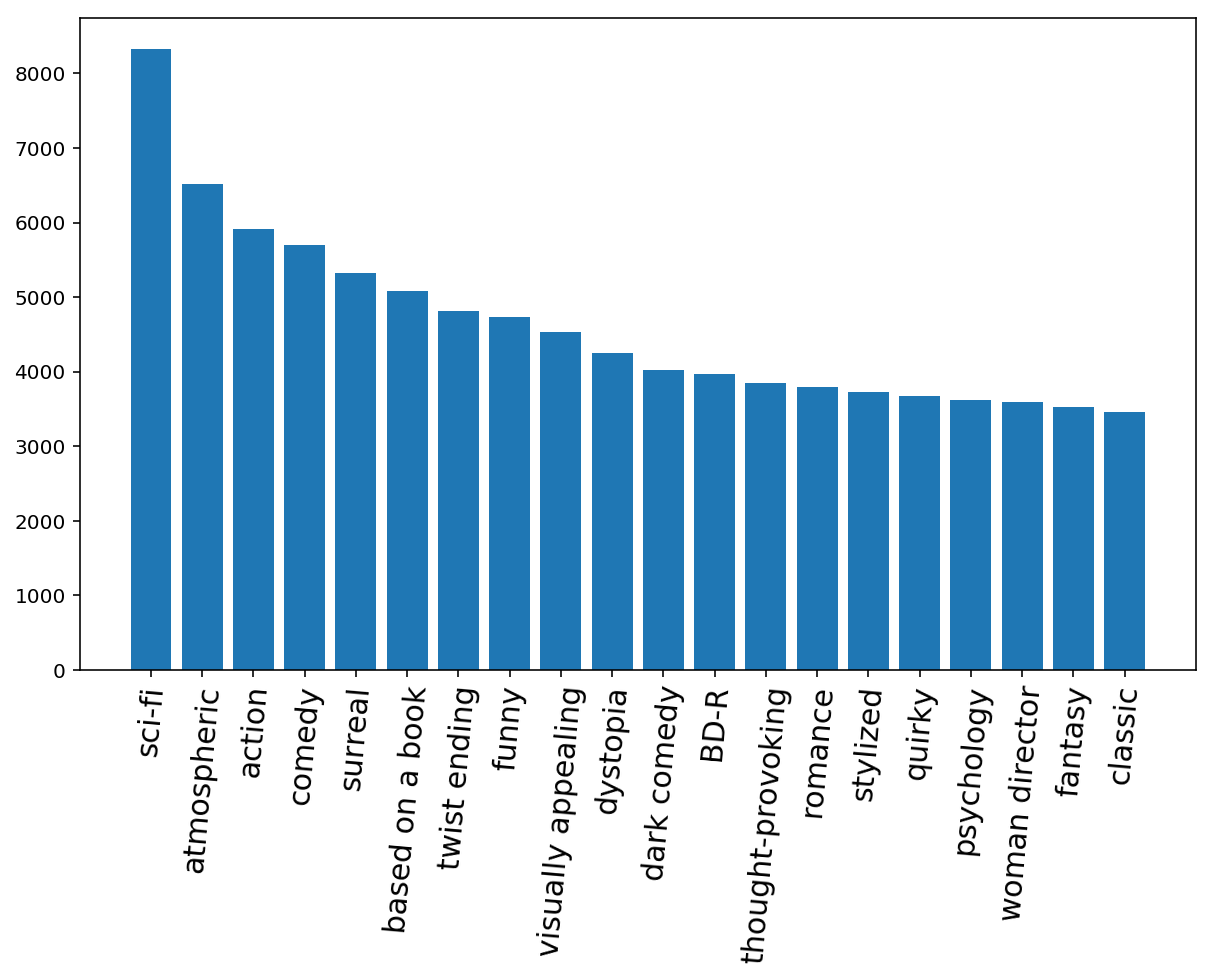

In [19]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values)
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [20]:
from operator import add, itemgetter

movie_ratings_number = ratings\
    .map(lambda rating: (rating.movie_id, 1))\
    .reduceByKey(add)\

movie_id_names = sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: (int(arr[0]), arr[1]))

movie_ratings_number\
    .join(movie_id_names)\
    .values()\
    .takeOrdered(10, key=lambda mr: -mr[0])

[(81491, 'Forrest Gump (1994)'),
 (81482, '"Shawshank Redemption'),
 (79672, 'Pulp Fiction (1994)'),
 (74127, '"Silence of the Lambs'),
 (72674, '"Matrix'),
 (68717, 'Star Wars: Episode IV - A New Hope (1977)'),
 (64144, 'Jurassic Park (1993)'),
 (60411, "Schindler's List (1993)"),
 (59184, 'Braveheart (1995)'),
 (58773, 'Fight Club (1999)')]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [21]:
ratings \
    .filter(lambda rating: rating.rating == 5) \
    .map(lambda rating: (rating.movie_id, 1)) \
    .reduceByKey(add) \
    .join(movie_id_names) \
    .values()\
    .takeOrdered(10, key=lambda mr: -mr[0])

[(39553, '"Shawshank Redemption'),
 (32169, 'Pulp Fiction (1994)'),
 (25918, 'Forrest Gump (1994)'),
 (25804, 'Star Wars: Episode IV - A New Hope (1977)'),
 (25482, '"Matrix'),
 (24853, "Schindler's List (1993)"),
 (24801, '"Silence of the Lambs'),
 (24418, '"Godfather'),
 (21585, '"Usual Suspects'),
 (21486, 'Fight Club (1999)')]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

<BarContainer object of 9 artists>

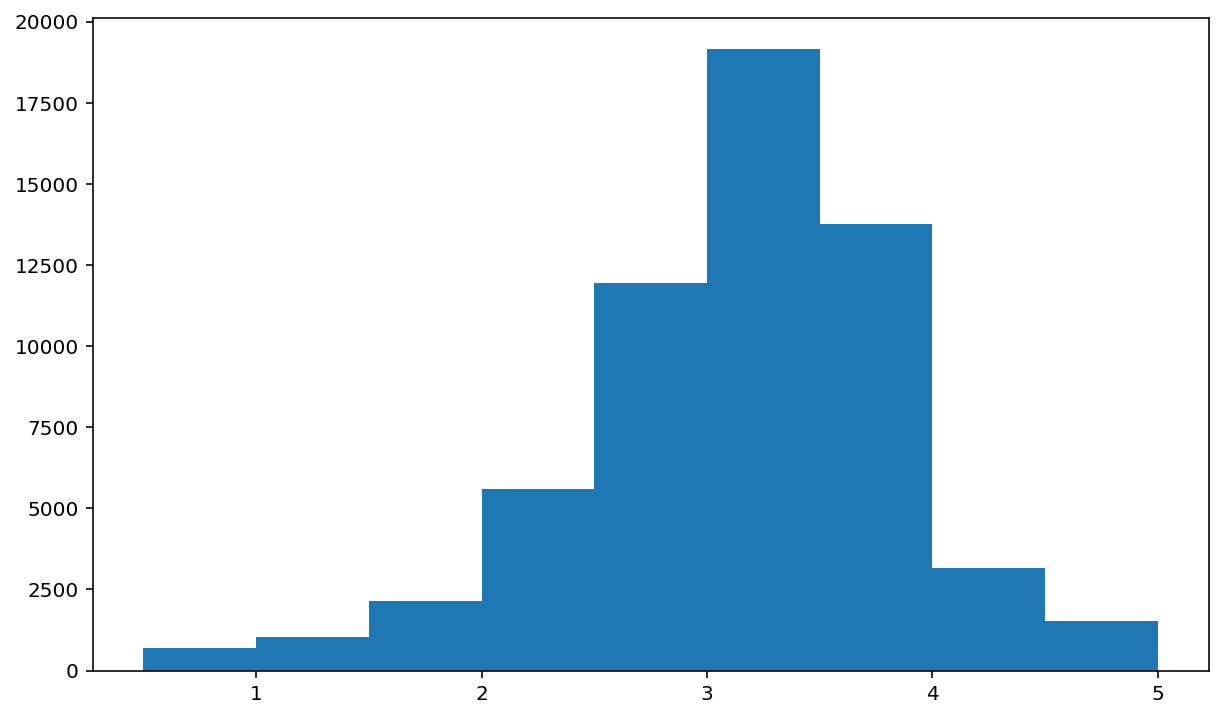

In [22]:
ratings_hist_borders, ratings_hist_values = movie_avg_rating\
    .values()\
    .histogram(buckets=9)

plt.subplots(figsize=(10, 6))
plt.bar(ratings_hist_borders[:-1], ratings_hist_values, align='edge', width=.5)

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

<BarContainer object of 50 artists>

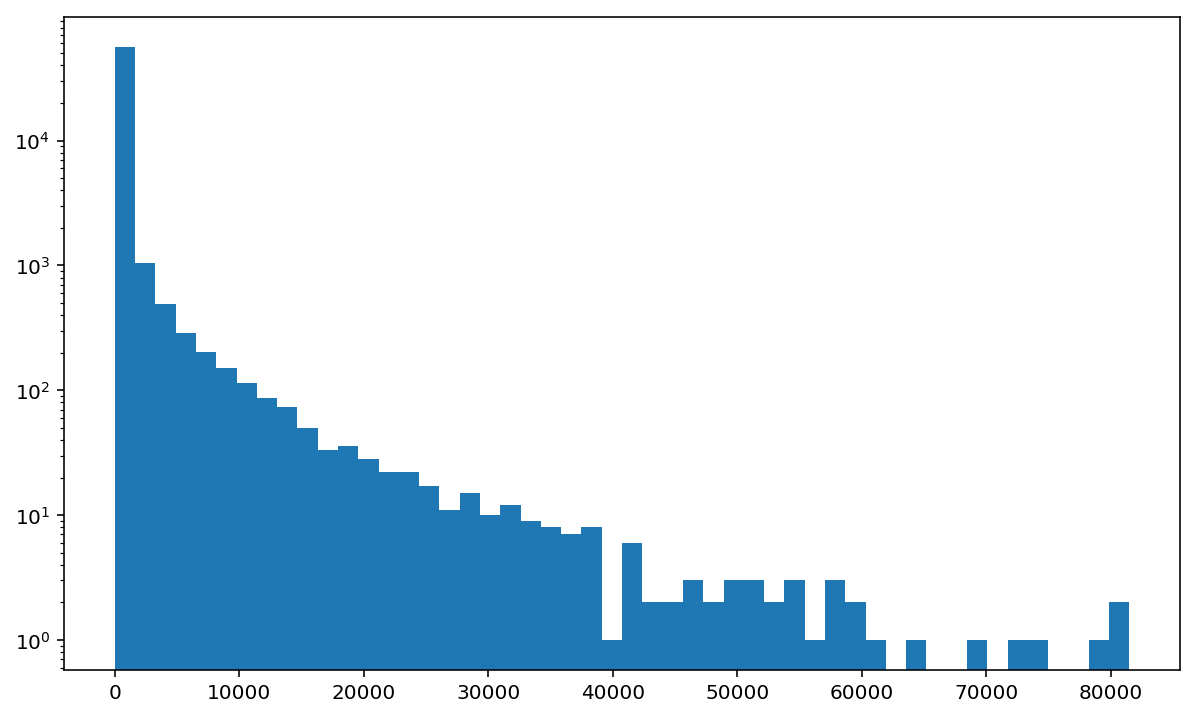

In [23]:
ratings_numbers_hist_borders, ratings_numbers_hist_values = movie_ratings_number\
    .values()\
    .histogram(50)

bar_width = ratings_numbers_hist_borders[1] - ratings_numbers_hist_borders[0]
plt.subplots(figsize=(10, 6))
plt.bar(ratings_numbers_hist_borders[:-1], ratings_numbers_hist_values, align='edge', width=bar_width, log=True)

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

<BarContainer object of 19 artists>

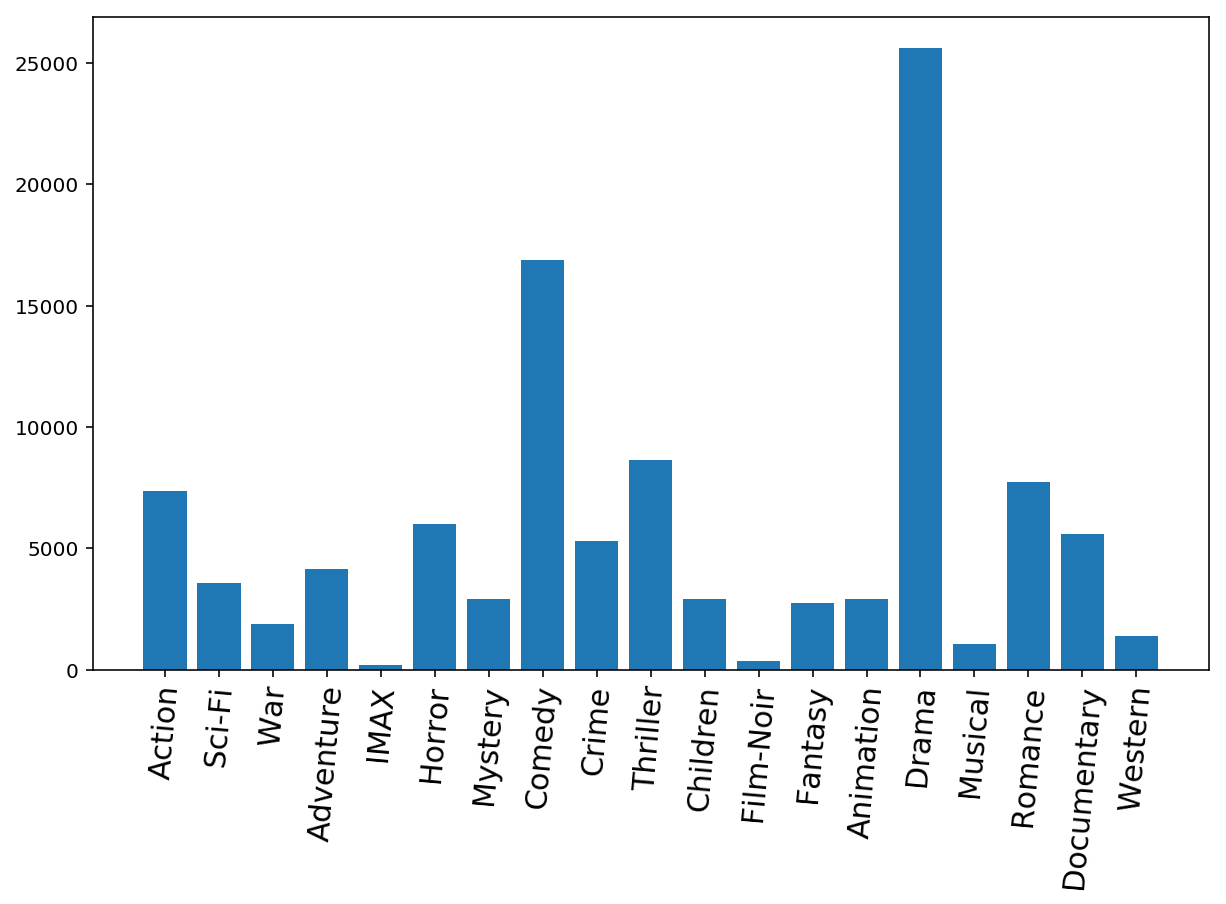

In [24]:
def id_genre_seq(movie_desc):
    movie_id = int(movie_desc[0])
    return [
        (movie_id, genre) 
        for genre in movie_desc[-1].split('|') 
        if genre != '(no genres listed)'
    ]

movie_id_genres = sc.textFile(MOVIES_PATH)\
    .filter(lambda s: s[0].isdigit())\
    .map(lambda desc: desc.split(','))\
    .flatMap(id_genre_seq)

genres_counts = movie_id_genres\
    .values()\
    .countByValue()

genres, counters = zip(*genres_counts.items())

plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(genres, counters)

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [25]:
import json

def movie_roles(movie_dict):
    movie_id = int(movie_dict['id'])
    return [
        (movie_id, int(person['id']))
        for person in movie_dict['casts']['cast']
    ]

def actor_names(movie_dict):
    return [
        (int(person['id']), person['name'])
        for person in movie_dict['casts']['cast']
    ]

TMDB_PATH = os.path.join(READ_DATA_PATH, 'tmdb.json')

movies_with_cast = sc.textFile(TMDB_PATH)\
    .map(json.loads)\
    .filter(lambda movie_dict: 'id' in movie_dict and 'casts' in movie_dict)

movie_actors = movies_with_cast\
    .flatMap(movie_roles)\
    .distinct()

actor_names = movies_with_cast\
    .flatMap(actor_names)\
    .distinct()

In [26]:
LINKS_PATH = os.path.join(READ_DATA_PATH, 'links.csv')

ml_tmdb_ids = sc.textFile(LINKS_PATH)\
    .map(lambda line: line.split(','))\
    .filter(lambda arr: arr[0].isdigit() and arr[2])\
    .map(lambda desc: (int(desc[0]), int(desc[2])))

In [27]:
TOM_HANKS_ID = 31

tom_hanks_movies = ml_tmdb_ids\
    .join(movie_id_names)\
    .values()\
    .join(
        movie_actors\
            .filter(lambda movie_actor: movie_actor[1] == TOM_HANKS_ID)
    )\
    .values()\
    .keys()\
    .collect()

print(tom_hanks_movies)

['Captain Phillips (2013)', 'Catch Me If You Can (2002)', 'Nothing in Common (1986)', 'Beyond Boundaries: The Harvey Weinstein Scandal (2018)', 'Toy Story of Terror (2013)', 'Toy Story 3 (2010)', 'Quincy (2018)', "You've Got Mail (1998)", '"Green Mile', 'Bonfire of the Vanities (1990)', 'Bridge of Spies (2015)', '"Terminal', 'The Post (2017)', '"Celluloid Closet', '"Money Pit', '"Simpsons Movie', 'Toy Story That Time Forgot (2014)', 'Road to Perdition (2002)', "Defying the Nazis: The Sharps' War (2016)", 'Punchline (1988)', 'Mazes and Monsters (1982)', 'The Circle (2016)', 'Joe Versus the Volcano (1990)', 'Bachelor Party (1984)', '"Extraordinary Voyage', 'Everything Is Copy (2015)', 'Larry Crowne (2011)', '"Pixar Story', 'Cast Away (2000)', 'Spielberg (2017)', 'Cloud Atlas (2012)', '"\'burbs', 'That Thing You Do! (1996)', 'Saving Mr. Banks (2013)', 'Killing Lincoln (2013)', '"League of Their Own', 'Turner & Hooch (1989)', '"Polar Express', '"Great Buck Howard', 'Dragnet (1987)', 'And t

In [30]:
actor_role_number = movie_actors\
    .values()\
    .map(lambda actor: (actor, 1))\
    .reduceByKey(add)
    
popular_actors = actor_role_number\
    .join(actor_names)\
    .values()\
    .takeOrdered(10, key=lambda ac: -ac[0])
    
print(popular_actors)

[(378, 'Bess Flowers'), (182, 'Frank Welker'), (175, 'Christopher Lee'), (150, 'Irving Bacon'), (146, 'John Carradine'), (142, 'John Wayne'), (140, 'Mel Blanc'), (137, 'Clarence Nash'), (133, 'Samuel L. Jackson'), (130, 'Eric Roberts')]


### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

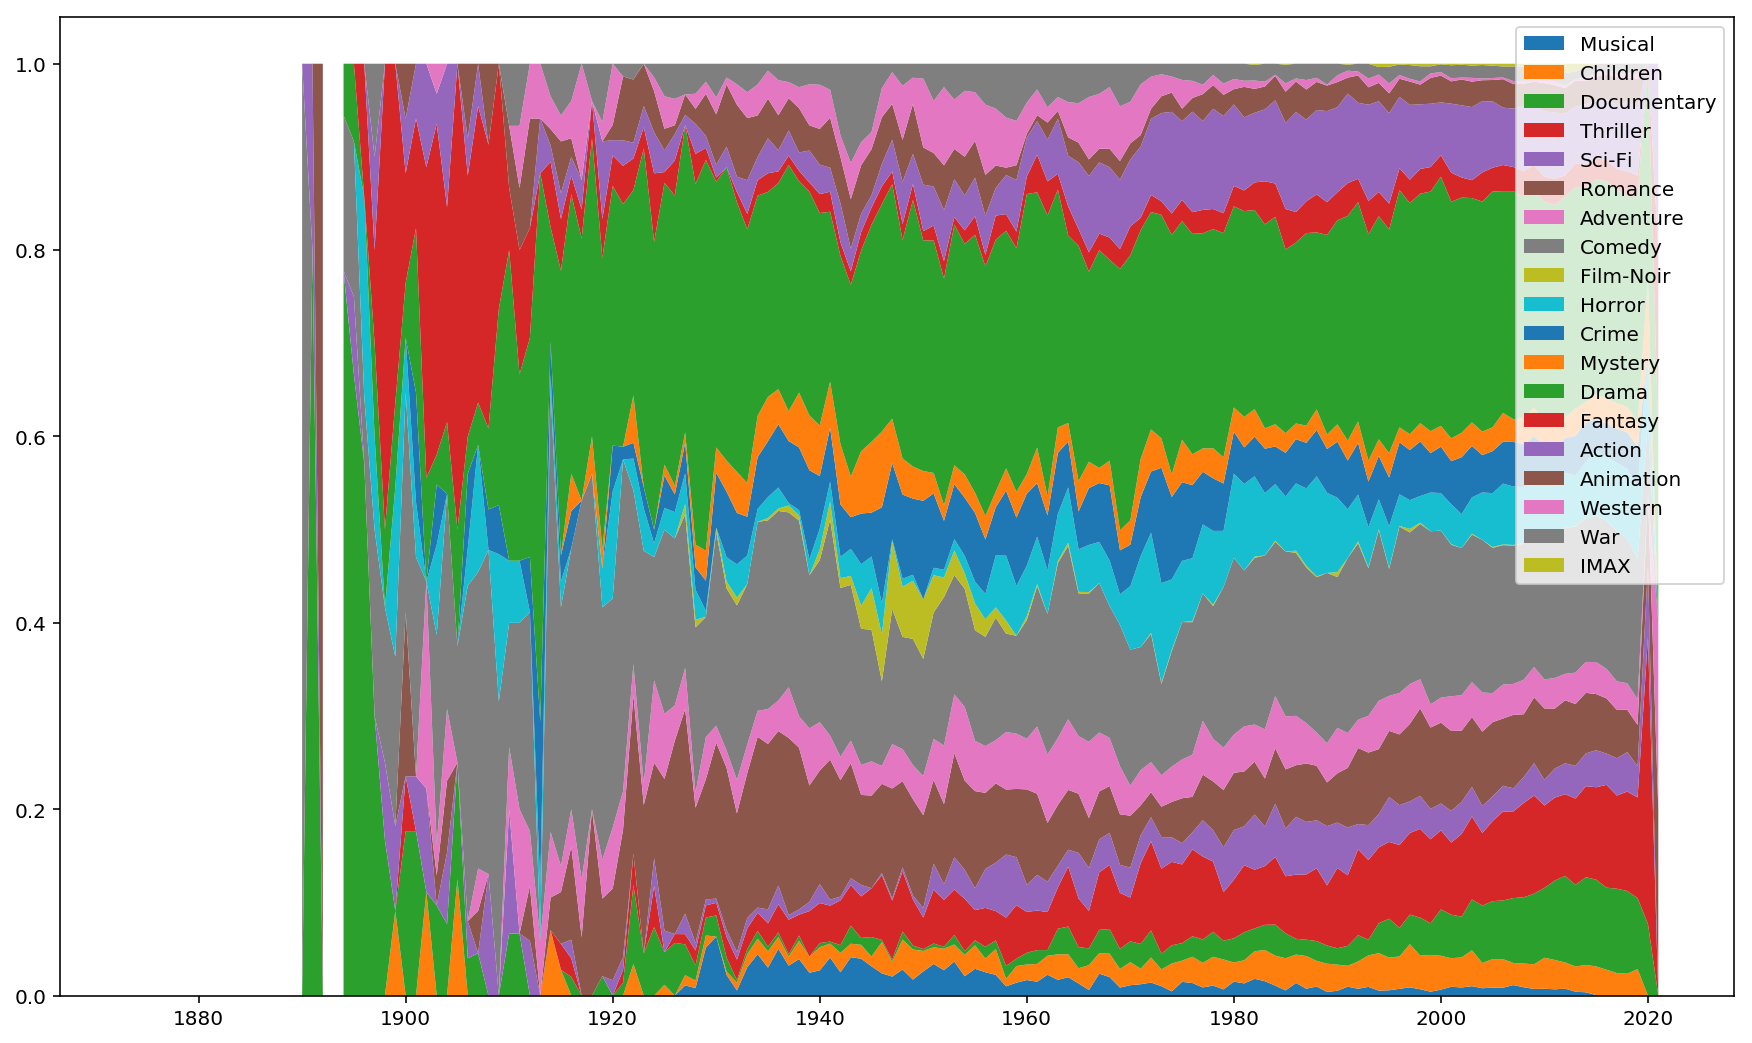

In [33]:
import numpy as np

movie_years = sc.textFile(TMDB_PATH)\
    .map(json.loads)\
    .filter(lambda movie_dict: 
            'id' in movie_dict and 
            'release_date' in movie_dict and 
            movie_dict['release_date']
    )\
    .map(lambda movie_dict: (int(movie_dict['id']), int(movie_dict['release_date'][:4])))

first_year, last_year = movie_years.values().min(), movie_years.values().max()
n_years = last_year - first_year + 1
one_hots = np.eye((n_years))

genre_labels_counters = ml_tmdb_ids\
    .join(movie_id_genres)\
    .values()\
    .join(movie_years)\
    .values()\
    .mapValues(lambda year: one_hots[year - first_year])\
    .reduceByKey(np.add)

total_year_counters = genre_labels_counters\
    .values()\
    .sum()

genre_labels_shares = genre_labels_counters\
    .mapValues(lambda counters: counters / total_year_counters)\
    .collect()

genre_labels, genre_shares = zip(*genre_labels_shares)

plt.subplots(figsize=(15, 9))
plt.stackplot(np.arange(first_year, last_year + 1), genre_shares, labels=genre_labels)
plt.legend()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text xticklabel objects>)

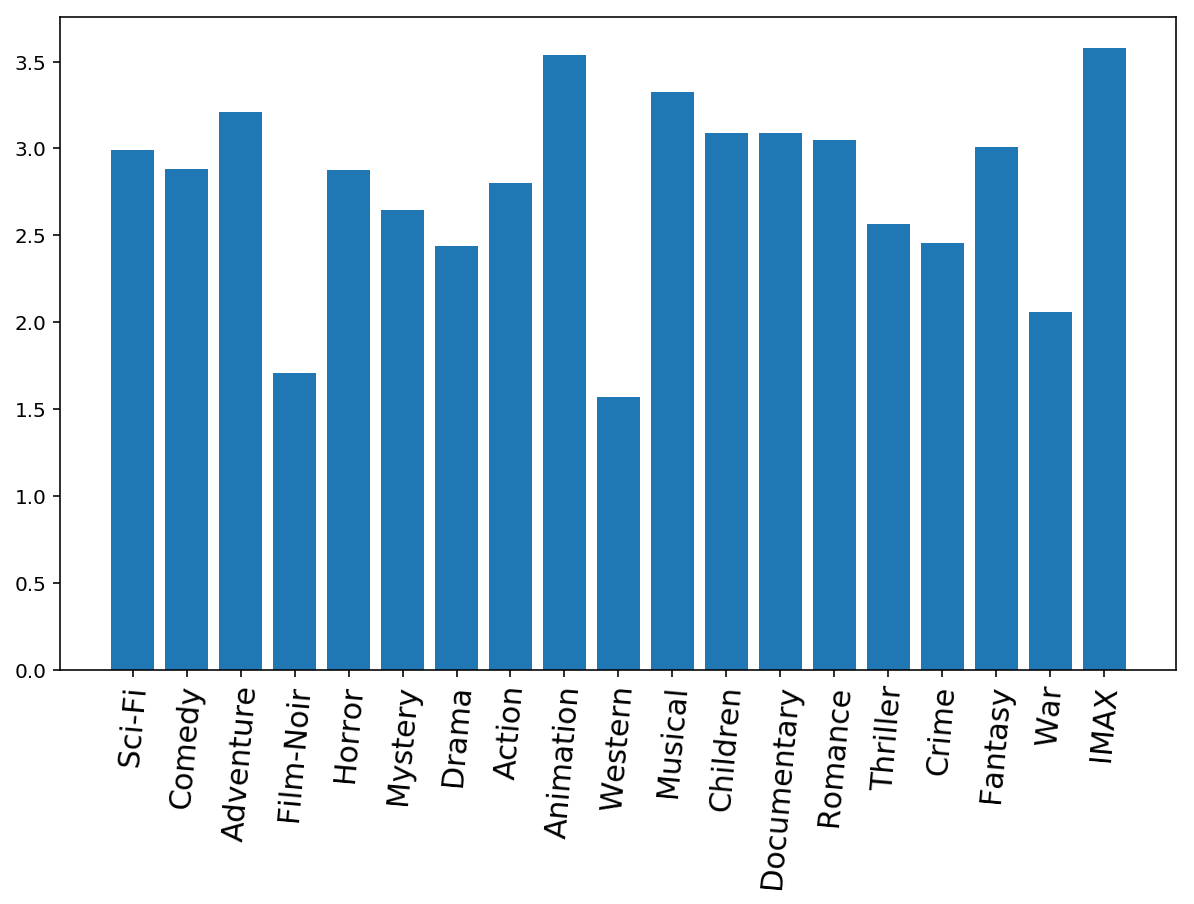

In [34]:
def valid_movie_dict_roi(movie_dict):
    return 'id' in movie_dict and \
           'budget' in movie_dict and \
           'revenue' in movie_dict

movie_budgets_revenues = sc.textFile(TMDB_PATH)\
    .map(json.loads)\
    .filter(lambda movie_dict:
           'id' in movie_dict and \
           'budget' in movie_dict and \
           'revenue' in movie_dict
    )\
    .map(lambda movie_dict: (movie_dict['id'], (movie_dict['budget'], movie_dict['revenue'])))

genre_budgets_revenues = ml_tmdb_ids\
    .join(movie_id_genres)\
    .values()\
    .join(movie_budgets_revenues)\
    .values()

def genre_avg(genre_measure):
    return genre_measure\
        .reduceByKey(add)\
        .map(lambda gp: (gp[0], gp[1] / genres_counts[gp[0]]))

genre_budgets = genre_budgets_revenues\
    .mapValues(itemgetter(0))
genre_mean_budgets = genre_avg(genre_budgets)

genre_revenues = genre_budgets_revenues\
    .mapValues(itemgetter(1))
genre_mean_revenues = genre_avg(genre_revenues)

genre_rois = genre_mean_budgets\
    .join(genre_mean_revenues)\
    .mapValues(lambda br: br[1] / br[0])\
    .collect()

genre_names_list, genre_rois_list = zip(*genre_rois)
plt.subplots(figsize=(10, 6))
plt.bar(genre_names_list, genre_rois_list)
plt.xticks(rotation=85, fontsize=15)